# A Jupyter notebook to read tracking files and (ultimately) create a data package representation of these 

This notebook shows how to generate **objects** and **events** csv files from CMSO sample files, and then prepares a datapackage representation of these.

requires python 3.3.0

In [2]:
# import needed libraries
import sys
import io
import os
import csv
import pandas as pd

This exercise is here shown for data contained in different folders.

Choose one of the following files to reproduce this code, or, alternatively, add the path of another file you'd like to use.


(Comment the files you will **NOT** use).

In [3]:
# f = os.path.join("VIB", "tracking examples", "Ugent", "trajectories.csv") # Sami's toolbox - VIB - on UGent data
# f = os.path.join("VIB", "tracking examples", "Essen", "exp1", "trajectories.csv") # Sami's toolbox - VIB - on Essen data

f = os.path.join("TrackMate", "tm_example.xml") # example of a TrackMate file

# f = os.path.join("Essen", "tracks_ctr.csv") # Essen's commercial toolbox
# f = os.path.join("Essen", "tracks_CXCL1.csv") # Essen's commercial toolbox
# f = os.path.join("Essen", "tracks_CXCL8.csv") # Essen's commercial toolbox

# f = os.path.join("Radboudumc", "ExampleFile1_NucleusFeatures.xls") # an xls file (Radboudumc)
# f = os.path.join("UGent", "0001_mode1_z000_f000_tracking.txt") # a single-cell tracking UGent (CELLMIA commercial s/w)

The first part of this notebook reads some tracking files, and splits these up in **objects** and **events** csv files.

In [4]:
# utility function needed to read Excel files
import xlrd
from xlrd import XLRDError

def xls_to_csv(xls_file):
    
    x =  xlrd.open_workbook(xls_file)
    x1 = x.sheet_by_index(0)
    name, extension = os.path.splitext(xls_file)
    csvfile = open(name + '.csv', 'wb')
    writecsv = csv.writer(csvfile, quoting=csv.QUOTE_ALL)

    for rownum in xrange(sh.nrows):
        writecsv.writerow(x1.row_values(rownum))

    csvfile.close()

In [5]:
# utility function to read a TrackMate XML file and convert it to a plain csv
import xml.etree.ElementTree as ET
def trackMate_to_csv(trackMate_file):
    tree = ET.parse(trackMate_file)
    root = tree.getroot()
    print('>>>')
    print('Reading a TrackMate XML file version {}'.format(root.attrib.get('version')))
    
    # dictionary for the spots
    spots_dict = {}
    for child in root.find('Model'):
        if child.tag == 'AllSpots':
            spots = child
            for spot_in_frame in spots.getchildren():
                for spot in spot_in_frame.getchildren():
                    spot_id = int(spot.get('ID'))
                
                    position_x = float(spot.get('POSITION_X'))
                    position_y = float(spot.get('POSITION_Y'))
                    position_t = float(spot.get('POSITION_T'))
                
                    spots_dict[spot_id] = (position_x, position_y, position_t)
                
    print('>>> Found {} unique spots'.format(len(spots_dict)))
    
    # dictionary for the tracks
    tracks_dict = {}
    for child in root.find('Model'):
        if child.tag == 'AllTracks':
            tracks = child
            for track in tracks.getchildren():
                track_index = int(track.get('TRACK_INDEX'))
                tracks_dict[track_index] = []
                for edge in track.getchildren():
                    spot_source_id = int(edge.get('SPOT_SOURCE_ID'))
                    spot_target_id = int(edge.get('SPOT_TARGET_ID'))
                
                    tracks_dict[track_index].append(spots_dict.get(spot_source_id))
                    tracks_dict[track_index].append(spots_dict.get(spot_target_id))
            
    print('>>> Found {} unique tracks'.format(len(tracks_dict)))

    # write the dictionary to file
    name, extension = os.path.splitext(trackMate_file)
    csvfile = open(name + '.csv', 'w')
    writecsv = csv.writer(csvfile, lineterminator='\n')
    # write header
    writecsv.writerow(["trackID", "x", "y", "t"])

    for key, value in tracks_dict.items():
        for element in tracks_dict.get(key):
            row = [key, element[0], element[1], element[2]]
            writecsv.writerow(row)
    
    csvfile.close() 

In [6]:
# takes file chosen and # of rows to visualize
def import_file(f, n):
    #if an excel file, try to read it as such
    if f.endswith('.xls'):
        try:
            xls_to_csv(f)
        except XLRDError:
            #copy the file and save it as csv
            import shutil
            name, extension = os.path.splitext(f)
            shutil.copyfile(f, name + '.csv')
            f = name + '.csv'
            print('Not an excel file.' + ' Copied and simply renamed to csv.')
    
    elif f.endswith('.xml'):
        trackMate_to_csv(f)
        name, extension = os.path.splitext(f)
        f = name + '.csv'
    
    # open the file and show a quick preview
    print('>>> opening file: %s' %f)
    with open(f, 'r') as reader:
        for i in range(n):
            if i == 0:
                print('>>> header of the file:')
            elif i == 1:
                print('>>> rest of the file:')
            print(reader.readline()) # print header
    return f

In [7]:
f = import_file(f, 5)

>>>
Reading a TrackMate XML file version 2.8.1
>>> Found 6000 unique spots
>>> Found 60 unique tracks
>>> opening file: TrackMate\tm_example.csv
>>> header of the file:
trackID,x,y,t

>>> rest of the file:
0,126.22603218269077,88.29527365416614,16.0

0,125.86267274728921,92.52166738895627,17.0

0,87.64020041681644,26.819751823197848,77.0

0,86.57960492296867,24.210292719400023,78.0



In [8]:
# group the tabular data by the joint_identifier
def group_by_joint_id(f, joint_id):
    df = pd.read_table(f, sep=None, engine='python')
    # try to group by the joint_id
    try:
        grouped = df.groupby(joint_id)
        print(grouped.size()[:5])
        return grouped 
    except KeyError: # throw an error if the wrong id is passed
        print('Seems like ' + joint_id + " is not the right joint_identifier for " + os.path.basename(f))
        return None

In [9]:
# the joint_id needs to be provided by the user
# this is one of the column headers in the tracking file, and will most likely be of the form:
# track_no, Track ID, object_ID, Track N, and such
joint_identifier = 'trackID'
G = group_by_joint_id(f, joint_identifier)
print('Type of G: {}'.format(type(G)))

trackID
0    198
1    198
2    198
3    198
4    198
dtype: int64
Type of G: <class 'pandas.core.groupby.DataFrameGroupBy'>


In [10]:
# create objects and events dataframes
def split_in_objs_evnts(grouped):
    # put everything back into a dataframe
    dfs = []
    for name, group in grouped:
        df = group.reset_index()
        dfs.append(df)
        
    objects_df = pd.concat(dfs)
 
    events_df = pd.DataFrame(grouped.size()).reset_index()
    events_df.columns = [joint_identifier, 'events_size']
  
    return {'objects':objects_df, 'events':events_df}

In [11]:
# the dictionary
D = split_in_objs_evnts(G)

# make directory for the csv and the dp representation
wd = os.path.dirname(os.path.realpath(f))
directory = wd + os.sep + 'dp'
if not os.path.exists(directory):
    os.makedirs(directory)

In [12]:
# write the dataframes to csv
for k, v in D.items():
    v.to_csv(directory + os.sep + k + '.csv', index = False)

From here on, the code takes care of the data package representation

In [13]:
# requires pip install datapackage
# requires pip install jsontableschema
import datapackage as dp
import jsontableschema
from jsontableschema import infer

In [14]:
import collections
from collections import defaultdict
author = 'author'
author_email = 'author@email.com'

# the top level information
top = (
    ('title', 'cell tracking file'),
    ('name', 'tracking-file'),
    ('author', author),
    ('author_email', author_email)
    )

top_dict = defaultdict(list)
for k, v in top:
    top_dict[k].append((v))

In [15]:
top_dict.items()

dict_items([('title', ['cell tracking file']), ('author_email', ['author@email.com']), ('name', ['tracking-file']), ('author', ['author'])])

In [16]:
# instanciate the data package representation
myDP = dp.DataPackage()
# top level information
for k, v in top_dict.items():
    myDP.descriptor[k] = v

myDP.descriptor['resources'] = []

# events 
key = 'events'
events_table = D.get(key)
path = key + '.csv'
with io.open(directory + os.sep + key + '.csv') as stream:
        headers = stream.readline().rstrip('\n').split(',')
        values = csv.reader(stream)
        schema = infer(headers, values, row_limit = 50, primary_key=joint_identifier)
        referenced_resource = key + 'Table'
        
myDP.descriptor['resources'].append(
    {"name": key + 'Table',
     "path": path,
     "schema": schema,
    }
)

# objects
key = 'objects'
objects_table = D.get(key)
path = key + '.csv'
with io.open(directory + os.sep + key + '.csv') as stream:
        headers = stream.readline().rstrip('\n').split(',')
        values = csv.reader(stream)
        schema = infer(headers, values, row_limit = 50)
        schema['foreignKeys'] = [{
              "fields": joint_identifier,
              "reference": {
                "datapackage": "",
                "resource": referenced_resource,
                "fields": joint_identifier
              }
              }]

myDP.descriptor['resources'].append(
    {"name": key + 'Table',
     "path": path,
     "schema": schema,
    }
)

print (myDP.to_json())

{"title": ["cell tracking file"], "author": ["author"], "name": ["tracking-file"], "author_email": ["author@email.com"], "resources": [{"schema": {"fields": [{"constraints": {"unique": true}, "name": "trackID", "description": "", "title": "", "type": "integer", "format": "default"}, {"title": "", "type": "integer", "format": "default", "name": "events_size", "description": ""}], "primaryKey": "trackID"}, "name": "eventsTable", "path": "events.csv"}, {"schema": {"fields": [{"title": "", "type": "integer", "format": "default", "name": "index", "description": ""}, {"title": "", "type": "integer", "format": "default", "name": "trackID", "description": ""}, {"title": "", "type": "number", "format": "default", "name": "x", "description": ""}, {"title": "", "type": "number", "format": "default", "name": "y", "description": ""}, {"title": "", "type": "number", "format": "default", "name": "t", "description": ""}], "foreignKeys": [{"fields": "trackID", "reference": {"datapackage": "", "fields":

In [17]:
# write the dp.json to file
with open(directory + os.sep + 'dp.json', 'w') as f:
    f.write(myDP.to_json())

In [18]:
for fk in schema.get('foreignKeys', []):
    print(fk)
    resource = fk['reference']['resource']
    print(resource)

{'fields': 'trackID', 'reference': {'datapackage': '', 'fields': 'trackID', 'resource': 'eventsTable'}}
eventsTable


In [19]:
# push the data package to a pandas storage
descr = directory + os.sep + 'dp.json'
stg = dp.push_datapackage(descriptor = descr, backend = 'pandas')
print(stg.buckets)

['events___eventstable', 'objects___objectstable']


In [20]:
objects = stg['objects___objectstable']
events = stg['events___eventstable']
print(objects.head()), print(events.head())

   index  trackID           x          y     t
0      0        0  126.226032  88.295274  16.0
1      1        0  125.862673  92.521667  17.0
2      2        0   87.640200  26.819752  77.0
3      3        0   86.579605  24.210293  78.0
4      4        0   86.579605  24.210293  78.0
         events_size
trackID             
0                198
1                198
2                198
3                198
4                198


(None, None)

In [21]:
events.reset_index(inplace=True)  
print(events.head())

   trackID  events_size
0        0          198
1        1          198
2        2          198
3        3          198
4        4          198


In [22]:
# aggregation
trajectories = pd.merge(objects, events, how = 'outer', on = joint_identifier)
print(trajectories.head())

   index  trackID           x          y     t  events_size
0      0        0  126.226032  88.295274  16.0          198
1      1        0  125.862673  92.521667  17.0          198
2      2        0   87.640200  26.819752  77.0          198
3      3        0   86.579605  24.210293  78.0          198
4      4        0   86.579605  24.210293  78.0          198


In [23]:
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

In [24]:
x = 'x' # this is not OK, should read header from dp
y = 'y'
trajectories.sort_values('t', axis = 0, inplace = True) # also time header should be read from dp

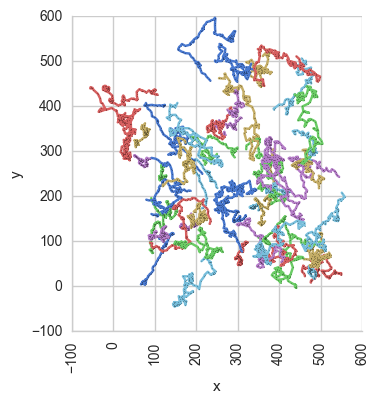

In [25]:
grid = sns.FacetGrid(trajectories, hue=joint_identifier, size = 4, palette='muted')
grid.map(plt.plot, x, y, marker="o", ms=0.3)
grid.set_xticklabels(rotation=90)

**Normalize to origin of system**

In [26]:
x_norm = x + 'norm'
y_norm = y + 'norm'

In [27]:
def normalize(dataset):
    list_ = []
    for track in dataset[joint_identifier].unique():
        temp_tracks = dataset[dataset[joint_identifier]==track]
        # the first x and y values
        x0, y0 = temp_tracks.iloc[0][x], temp_tracks.iloc[0][y]
        for index, row in temp_tracks.iterrows():
            current_x, current_y = row[x], row[y]
            xn, yn = current_x - x0, current_y - y0
            
            temp_tracks_row = temp_tracks.loc[[index]] # pass a list to .loc to be sure to get a dataframe: behavior is not consistent!
            temp_tracks_row[x_norm], temp_tracks_row[y_norm] = xn, yn
            list_.append(temp_tracks_row)
            
    dataset = pd.concat(list_)
    return dataset

In [28]:
norm = normalize(trajectories)
print(norm.head())

      index  trackID           x           y    t  events_size      xnorm  \
8000   8000       40  377.337185  471.314040  0.0          198   0.000000   
8001   8001       40  381.662487  475.964489  1.0          198   4.325303   
8066   8066       40  381.662487  475.964489  1.0          198   4.325303   
8067   8067       40  364.494678  476.549622  2.0          198 -12.842507   
8022   8022       40  364.494678  476.549622  2.0          198 -12.842507   

         ynorm  
8000  0.000000  
8001  4.650449  
8066  4.650449  
8067  5.235582  
8022  5.235582  


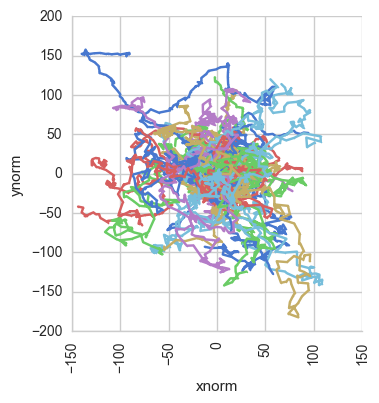

In [29]:
grid = sns.FacetGrid(norm, hue=joint_identifier, size=4, palette='muted')
grid.map(plt.plot, x_norm, y_norm, marker="o", ms=1)
grid.set_xticklabels(rotation=90)

**Compute turning angles**

In [30]:
import math
def compute_ta(dataset):
    list_ = []
    for track in dataset[joint_identifier].unique():
        temp_tracks = dataset[dataset[joint_identifier] == track]
        for i, row in enumerate(temp_tracks.iterrows()):
            temp_tracks_row = temp_tracks.iloc[[i]]
            if i == 0:
                previousX, previousY = row[1][x], row[1][y]
                temp_tracks_row['ta'] = float('NaN')
            else:
                delta_x, delta_y = row[1][x] - previousX, row[1][y] - previousY
                previousX, previousY = row[1][x], row[1][y]
                ta = math.atan2(delta_y, delta_x)
                temp_tracks_row['ta'] = ta

            list_.append(temp_tracks_row)

    dataset = pd.concat(list_)
    return dataset

In [31]:
norm2 = compute_ta(norm)

C:\Users\Paola\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Paola\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
theta = norm2.ta[~np.isnan(norm2.ta)]
theta_deg = theta.apply(math.degrees)
theta = pd.DataFrame(theta)
theta_deg = pd.DataFrame(theta_deg % 360) # (-180, + 180) mapped into (0, 360)

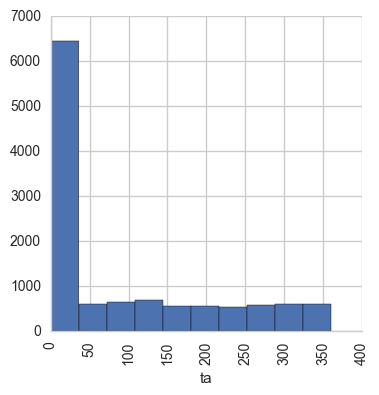

In [33]:
grid = sns.FacetGrid(theta_deg, size=4, palette='muted')
grid.map(plt.hist, 'ta', bins = 10)
grid.set_xticklabels(rotation=90)

In [34]:
def plot_polar(dataset, N):
    
    # dataset is the column of the frame to plot
    # N is the number of bin to use
    hist, bins = np.histogram(dataset, bins = N)
    
    # the width of the bins interval
    width = [t - s for s, t in zip(bins, bins[1:])]
    bins_ = bins[0:N] # exclude the last value 
    
    # the actual plotting logic
    g = sns.FacetGrid(theta, size = 4)
    radii = hist/max(hist)
    
    for ax in g.axes.flat:
        ax2 = plt.subplot(111, projection='polar')
        bars = ax2.bar(bins_, radii, width, bottom=0.0)
        for r,bar in zip(radii, bars):
            bar.set_facecolor(plt.cm.Spectral(r))
            bar.set_alpha(0.5)
    

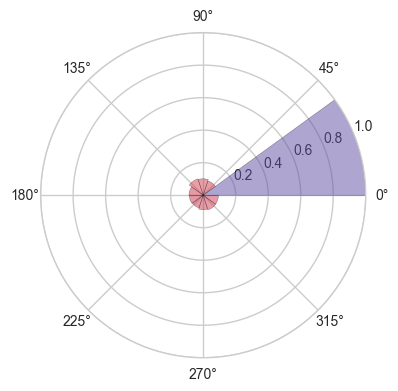

In [35]:
plot_polar(theta.ta, 10)

In [46]:
sample = norm.head(1000)
print(sample.shape)

(1000, 8)


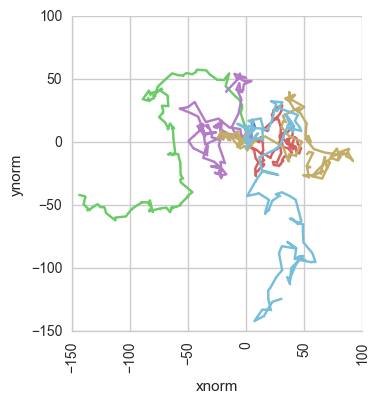

In [48]:
grid = sns.FacetGrid(norm_sample, hue=joint_identifier, size=4, palette='muted')
grid.map(plt.plot, x_norm, y_norm, marker="o", ms=1)
grid.set_xticklabels(rotation=90)

In [ ]:
norm_sample = compute_ta(sample)

C:\Users\Paola\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Paola\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
theta = norm_sample.ta[~np.isnan(norm_sample.ta)]
theta_deg = theta.apply(math.degrees)
theta = pd.DataFrame(theta)
theta_deg = pd.DataFrame(theta_deg % 360) # (-180, + 180) mapped into (0, 360)

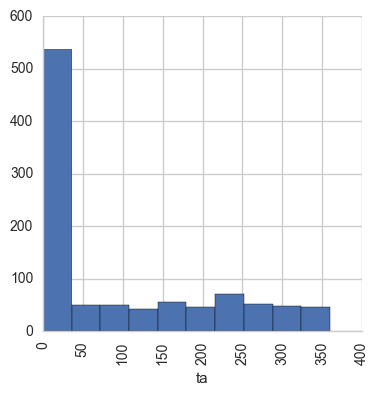

In [50]:
grid = sns.FacetGrid(theta_deg, size=4, palette='muted')
grid.map(plt.hist, 'ta', bins = 10)
grid.set_xticklabels(rotation=90)

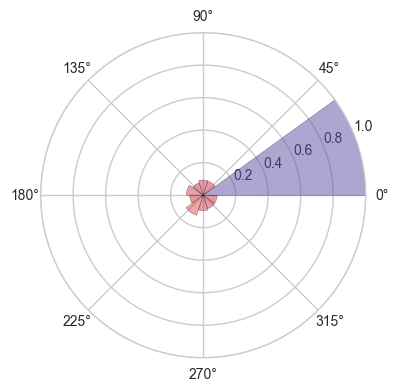

In [51]:
plot_polar(theta.ta, 10)